In [37]:
library(dplyr)
library(Seurat)
library(patchwork)

In [38]:
zehn.data <- Read10X(data.dir = "/home/rstudio/run071/run071_RSEC_MolsPerCell_MEX")

In [39]:
zehn <- CreateSeuratObject(counts = zehn.data, project = "zehn_dataset", min.cells = 3, min.features = 200)
ncol(zehn)

[1] 802

In [40]:
Assays(zehn) # Assay (v5) data with 16485 features for 802 cells
zehn[["RNA"]]
GetAssayData(zehn, slot = "counts")[, 1:30] #counts are inside Assays

[1] "RNA"

Assay (v5) data with 16485 features for 802 cells
First 10 features:
 A1BG-AS1, A2M, A2M-AS1, A2ML1, A2ML1-AS1, A3GALT2, AAAS, AACS, AACSP1,
AAGAB 
Layers:
 counts 

  [[ suppressing 30 column names ‘111840’, ‘146164’, ‘166368’ ... ]]

  [[ suppressing 30 column names ‘111840’, ‘146164’, ‘166368’ ... ]]

  [[ suppressing 30 column names ‘111840’, ‘146164’, ‘166368’ ... ]]



16485 x 30 sparse Matrix of class "dgCMatrix"
                                                                                   
A1BG-AS1                   .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
A2M                        .  .  . .  . .  . .  . .  . . . .  . . . 1  . .  .  .  .
A2M-AS1                    .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
A2ML1                      .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
A2ML1-AS1                  .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
A3GALT2                    .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
AAAS                       .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
AACS                       .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  1
AACSP1                     .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
AAGAB                      .  .  . .  . .  . .  . .  . . . .  . . . .  . .  .  .  .
AAK1                       .  

In [41]:
#QC
#calculates the percentage of counts originating from a set of features
#mitochondrial contamination
zehn[["percent.mt"]] <- PercentageFeatureSet(zehn, pattern = "^MT-")

In [42]:
# Show QC metrics for the first 5 cells ## the percent.mt is also added here
head(zehn@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
111840,zehn_dataset,3231,1490,14.020427
146164,zehn_dataset,2897,1317,11.287539
166368,zehn_dataset,2204,1003,13.793103
205244,zehn_dataset,815,564,9.693252
289640,zehn_dataset,1258,906,4.848967


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


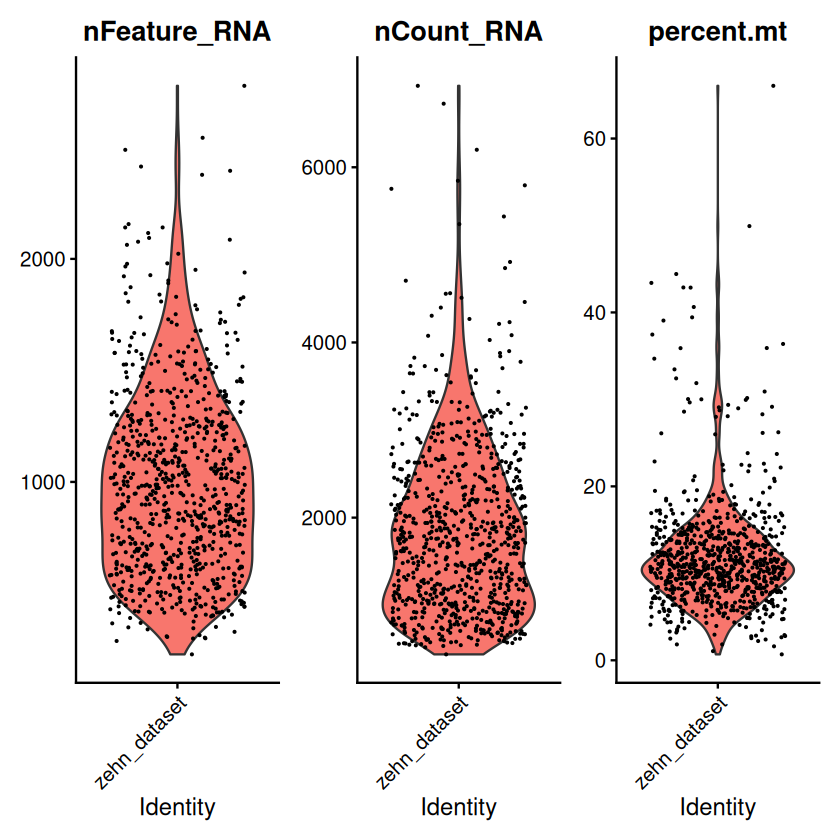

In [43]:
# Violin Plot
VlnPlot(zehn, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

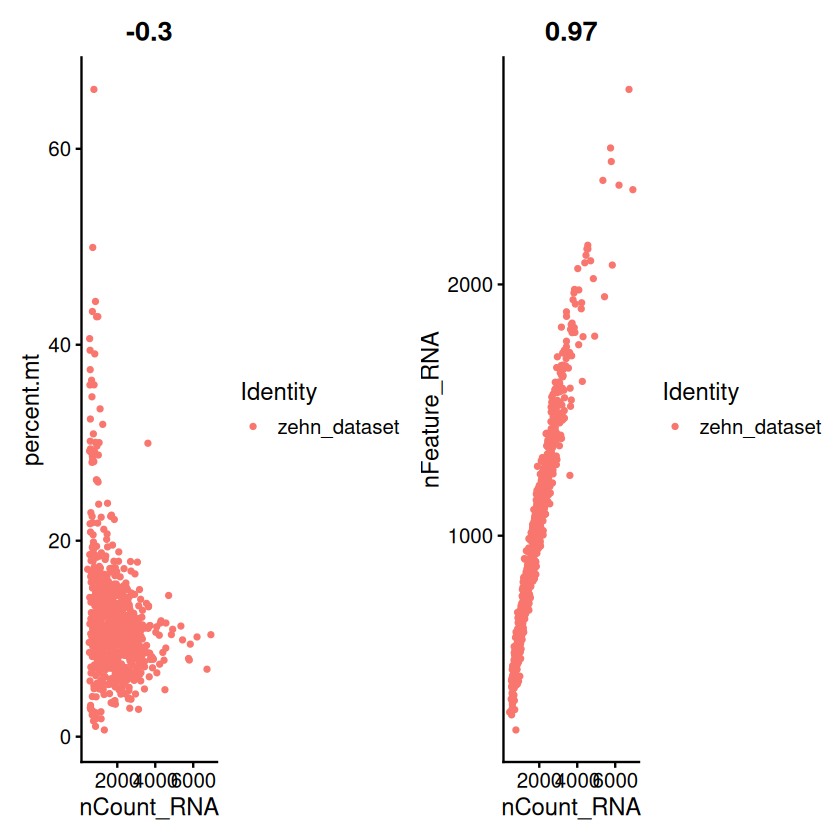

In [44]:
# func. FeatureScatter
plot1 <- FeatureScatter(zehn, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(zehn, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


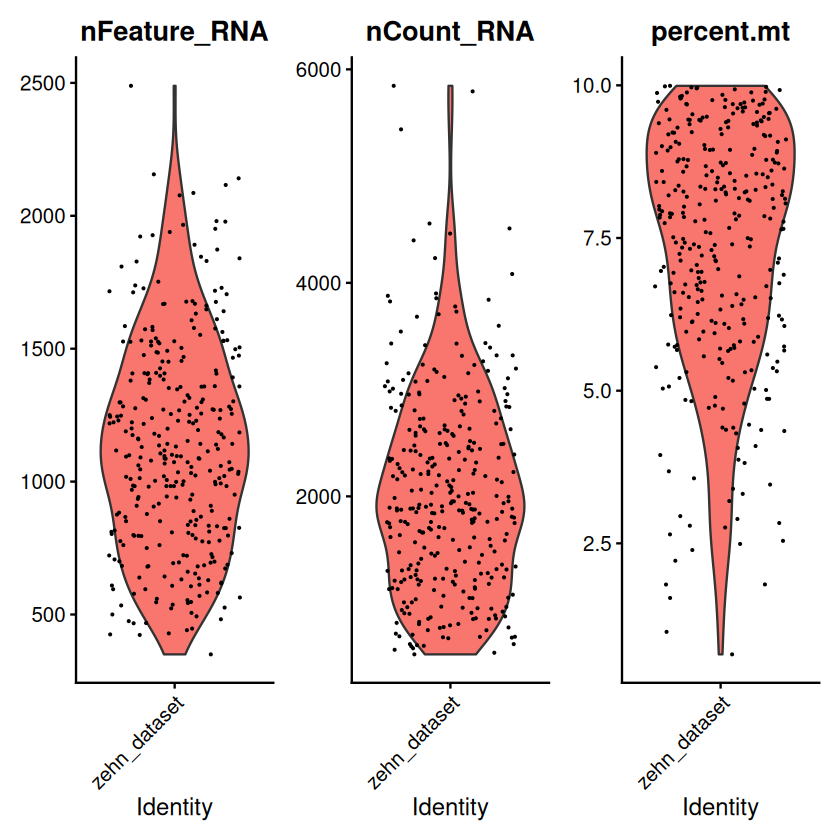

In [45]:
zehn_s <- subset(zehn, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)
VlnPlot(zehn_s, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [46]:
#zehn_s <- NormalizeData(zehn_s, normalization.method = "LogNormalize", scale.factor = 10000)
zehn_s <- NormalizeData(zehn_s)

Normalizing layer: counts



In [47]:
zehn_s <- FindVariableFeatures(zehn_s, selection.method = "vst", nfeatures = 2000)
zehn_s
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(zehn_s), 10)

Finding variable features for layer counts

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.2055”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.8381e-16”


An object of class Seurat 
16485 features across 321 samples within 1 assay 
Active assay: RNA (16485 features, 2000 variable features)
 2 layers present: counts, data

In [48]:
head(VariableFeatures(zehn_s), 10)

[1] "CCL4"     "HSPA1B"   "HLA-DRA"  "HSPA6"    "KLF4"     "GNLY"    
 [7] "HSPA1A"   "TYROBP"   "PSAP"     "HLA-DRB1"

In [49]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(zehn_s)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
pdf("/home/rstudio/variable_features_plot_with_labels.pdf", width = 12, height = 10)
plot1 + plot2
dev.off()

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


pdf 
  2

In [50]:
# Scaling needed prior to dimensionality red.n
# ScaleData() Shifts mean expression across cells to 0, Scales the variance across cells to 1
all.genes <- rownames(zehn_s)
#rownames(zehn_s)
zehn_s <- ScaleData(zehn_s, features = all.genes)
zehn_s[["RNA"]]$scale.data

Centering and scaling data matrix



,205244,289640,480269,544629,749304,985049,1136612,1185364,1328663,1379377,⋯,55553248,55580202,55688108,55741925,56164257,56169722,56172114,56200728,56491109,56566004
A1BG-AS1,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,⋯,6.87107230,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161,-0.12454161
A2M,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,⋯,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308,-0.17353308
A2M-AS1,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,⋯,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503,-0.11079503
A2ML1,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,⋯,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195,-0.09602195
A2ML1-AS1,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,⋯,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456,-0.05581456
A3GALT2,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,⋯,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445,-0.11090445
AAAS,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,⋯,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544,-0.15617544
AACS,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,4.15783363,⋯,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,-0.21818877,5.05064460,-0.21818877,-0.21818877,-0.21818877
AACSP1,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,⋯,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080,-0.07446080
AAGAB,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,⋯,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043,-0.22364043


In [51]:
### SCTransform() can also be used. As with ScaleData(), the function SCTransform() also includes a vars.to.regress parameter.

#zehn_s <- RunPCA(zehn_s, features = VariableFeatures(object = zehn_s))
#print(zehn_s[["pca"]], dims = 1:5, nfeatures = 5)
#npcs <- min(50, min_dim - 1)

# Print dimensions
print(paste("Number of cells:", ncol(zehn_s)))
print(paste("Number of variable features:", length(VariableFeatures(zehn_s))))
print(paste("Maximum possible PCs:", min(ncol(zehn_s), length(VariableFeatures(zehn_s))) - 1))

zehn_s <- RunPCA(zehn_s, features = VariableFeatures(object = zehn_s), npcs = 20)

[1] "Number of cells: 321"
[1] "Number of variable features: 2000"
[1] "Maximum possible PCs: 320"


PC_ 1 
Positive:  LILRB2, KLF4, CD163, FCER1G, MPEG1, MS4A6A, TMEM176B, HCK, RNASE6, CST3 
	   TYROBP, MARCKS, MNDA, CPVL, CSF2RB, CD93, LILRA6, CXCL8, FPR1, TGFBI 
	   OLR1, IGSF6, TNFAIP2, TLR2, AIF1, CD4, SLC15A3, ALDH2, LILRB4, RNF144B 
Negative:  CCL5, NR4A2, DUSP4, TRBC1, TRBC2, RNF19A, PPP1R16B, NKG7, PDE3B, CEMIP2 
	   PTPN22, PNISR, ITM2A, RANBP2, PDE7A, GZMA, CRTAM, EOMES, ATP1B3, IVNS1ABP 
	   GLCCI1, ITGAE, SMC5, PIK3R1, ATP11B, FAF1, CCSER2, CCND2, EIF2AK3, BOD1L1 
PC_ 2 
Positive:  CXCL2, EREG, CXCL3, LST1, ENSG00000257764, G0S2, CCL20, CLEC4E, S100A8, ENSG00000274213 
	   AQP9, CSTA, PLBD1, CD300E, FCN1, IL1B, KLF2, FGL2, TIMP1, BCL2A1 
	   IL7R, LYZ, S1PR1, ENSG00000255197, KYNU, C5AR1, SLC2A6, PID1, YBX3, LHFPL2 
Negative:  DUSP4, HLA-DRB1, RGS1, APOBEC3C, TNS3, AKAP5, TNFRSF9, MYO7A, VCAM1, CCL5 
	   CD74, HLA-DQA1, NKG7, ITGAE, HS3ST2, METTL7A, GSN, AHI1, PLTP, GZMA 
	   CXCL13, HLA-DRA, SNX9, SDS, PRDM1, C1orf54, CCND2, LGMN, TOX2, NRBP2 
PC_ 3 
Positive:  FCN1, IL1

PC_ 1 
Positive:  LILRB2, KLF4, CD163, FCER1G, MPEG1 
Negative:  CCL5, NR4A2, DUSP4, TRBC1, TRBC2 
PC_ 2 
Positive:  CXCL2, EREG, CXCL3, LST1, ENSG00000257764 
Negative:  DUSP4, HLA-DRB1, RGS1, APOBEC3C, TNS3 
PC_ 3 
Positive:  FCN1, IL1B, DUSP4, ENSG00000257764, G0S2 
Negative:  LGMN, C1orf54, GSN, METTL7A, HS3ST2 
PC_ 4 
Positive:  LINC-PINT, ZSWIM6, ALPK1, PRKCG, ARHGAP26 
Negative:  ACTB, HSP90AA1, VIM, FTL, HSPA1A 
PC_ 5 
Positive:  IFI27, ENSG00000266086, ADAMTSL4, ENSG00000289242, PCK2 
Negative:  UBE2E2, MYOF, ADAP2, DMXL2, ENSG00000273568 


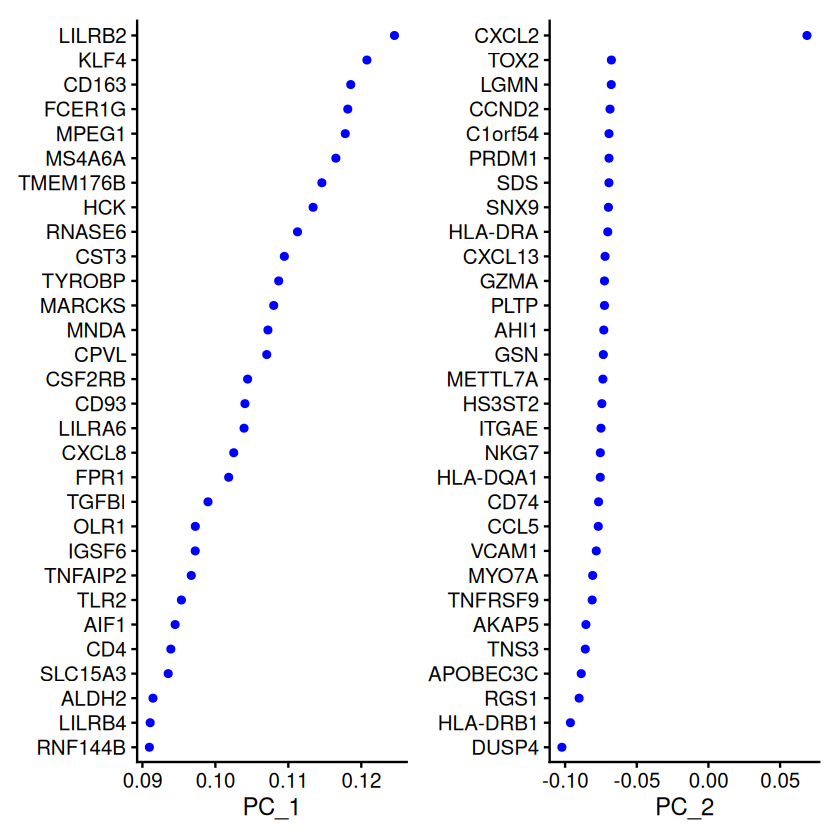

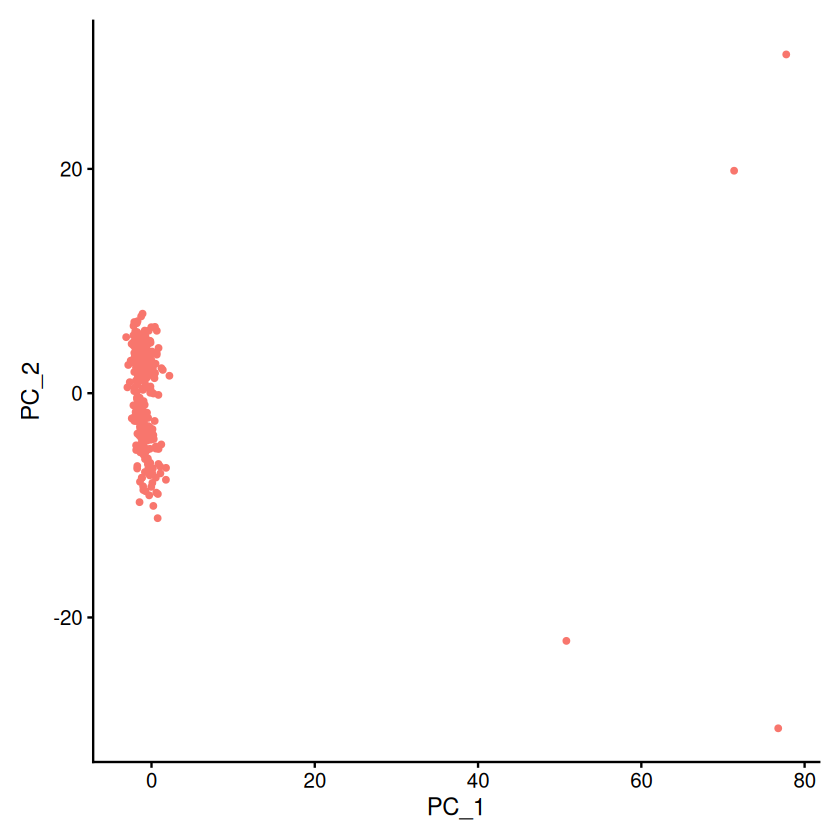

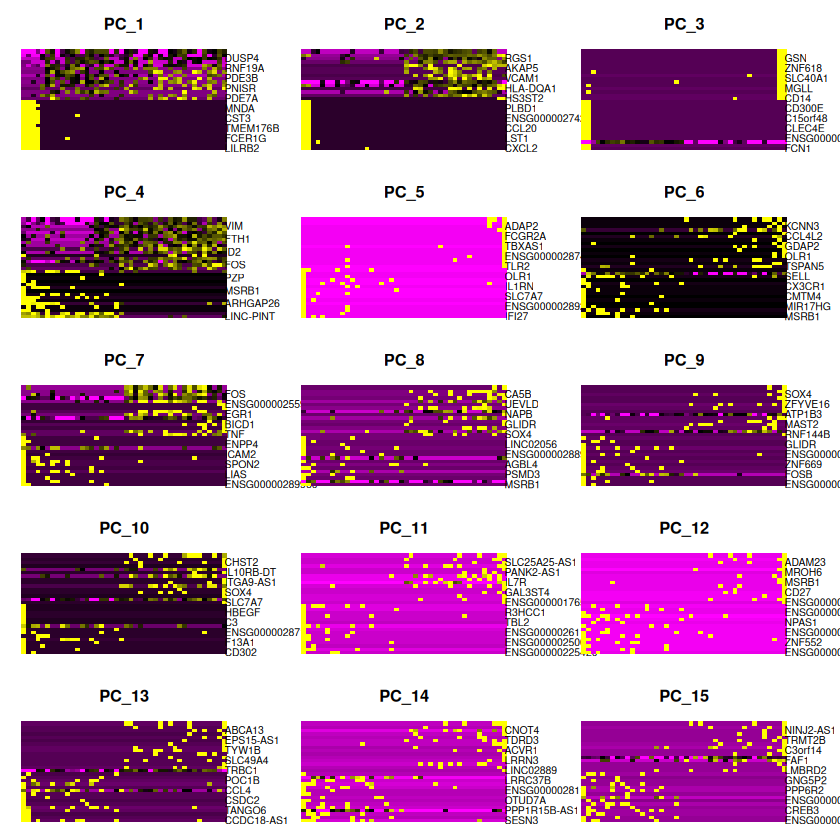

In [52]:
# PCA results interpreted in different ways
print(zehn_s[["pca"]], dims = 1:5, nfeatures = 5)
VizDimLoadings(zehn_s, dims = 1:2, reduction = "pca")
DimPlot(zehn_s, reduction = "pca") + NoLegend()
#DimHeatmap(zehn_s, dims = 1, cells = 42, balanced = TRUE)
DimHeatmap(zehn_s, dims = 1:15, cells = 42, balanced = TRUE)

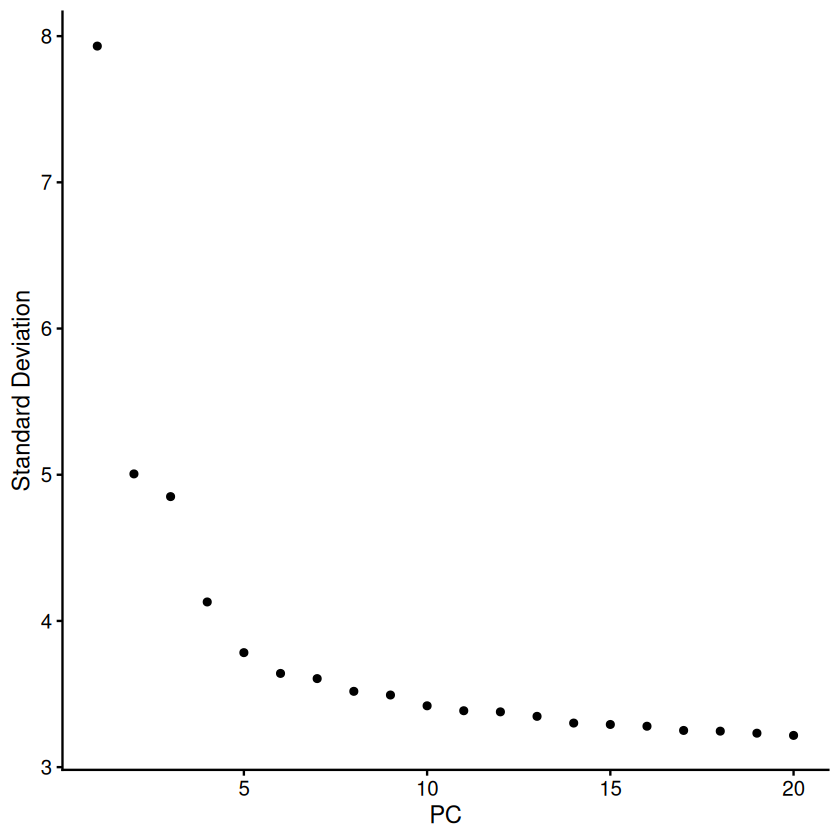

In [53]:
# ElbowPlot to understand the capture power of principal components
ElbowPlot(zehn_s) # Confusing results # elbow at 6 with percent.mt < 10

In [54]:
zehn_s <- FindNeighbors(zehn_s, dims = 1:20) # construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights # increasing from 1:10
zehn_s <- FindClusters(zehn_s, resolution = 1.0) # Group cells together, with the goal of optimizing the standard modularity function ## res 0.5 too low.
head(Idents(zehn_s)) # 4 levels/clusters

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 321
Number of edges: 15998

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4389
Number of communities: 3
Elapsed time: 0 seconds


205244 289640 480269 544629 749304 985049 
     2      0      1      0      2      0 
Levels: 0 1 2

14:42:13 UMAP embedding parameters a = 0.9922 b = 1.112

14:42:13 Read 321 rows and found 10 numeric columns

14:42:13 Using Annoy for neighbor search, n_neighbors = 30

14:42:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:42:13 Writing NN index file to temp file /tmp/RtmpqpJOaC/file303d984cb1

14:42:13 Searching Annoy index using 1 thread, search_k = 3000

14:42:13 Annoy recall = 100%

14:42:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:42:14 Initializing from normalized Laplacian + noise (using RSpectra)

14:42:14 Commencing optimization for 500 epochs, with 12094 positive edges

14:42:14 Optimization finished



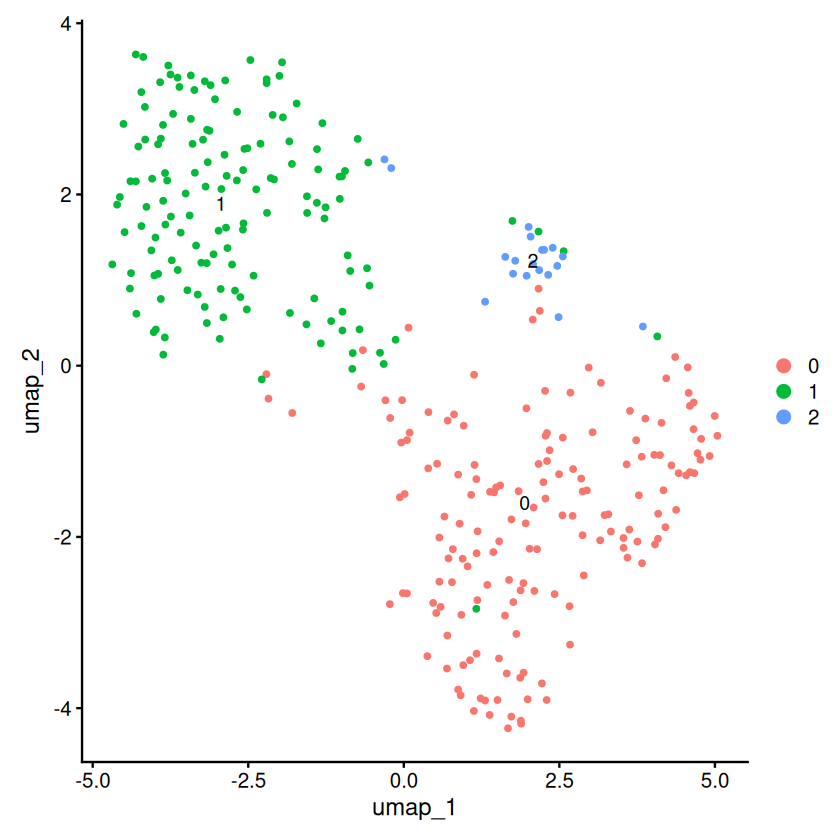

In [55]:
# Non-linear dimensional reduction (UMAP/tSNE)

zehn_s <- RunUMAP(zehn_s, dims = 1:10)
DimPlot(zehn_s, reduction = "umap", label = TRUE)

In [56]:
# marker finding ## What is this exactly?
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
zehn_s.markers <- FindAllMarkers(zehn_s, only.pos = TRUE)
zehn_s.markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
4.483422e-13,1.178999,0.844,0.739,7.390922e-09,0,RPS12
5.556707e-13,2.470458,0.544,0.205,9.160232e-09,0,KLF2
6.106198e-13,1.284557,0.856,0.646,1.006607e-08,0,HEXIM1
2.194644e-12,1.081544,0.881,0.776,3.617871e-08,0,RPL27A
3.474314e-12,1.030590,0.875,0.807,5.727407e-08,0,RPS6
3.077183e-11,4.064874,0.306,0.031,5.072736e-07,0,IL7R
4.825531e-11,1.027124,0.875,0.807,7.954889e-07,0,RPS20
5.591202e-11,1.060104,0.844,0.671,9.217097e-07,0,RPS3
1.416751e-10,1.229794,0.875,0.727,2.335513e-06,0,VIM


In [57]:
features = c(B='Ms4a1',B='Cd19',MM='Cd14',MM='Lyz2',MM='Fcgr3',MM='Ms4a7',MM='Fcer1g',MM='Cst3',MM='H2-Aa',MM='Ly6d',
  rRNA='AY036118',rRNA='Gm42418',Mphase='Cenpa',Mphase='Ccnb2',Mphase='Birc5',Mphase='Mki67',Sphase='Pcna',
  Sphase='Mcm3',Sphase='Ccne2','T'='Cd8b','T'='Cd8a','T'='Cd4','T'='Cd3g','T'='Cd3e','T'='Cd3d')

# Convert all gene symbols to uppercase
features_upper <- toupper(features)

# Now check against the Seurat object
present_features <- features_upper[features_upper %in% rownames(zehn_s)]
missing_features <- features_upper[!features_upper %in% rownames(zehn_s)]

cat("✅ Present genes:\n")
print(present_features)

cat("\n❌ Missing genes:\n")
print(missing_features)

✅ Present genes:
       B       MM       MM       MM       MM   Mphase   Mphase   Mphase 
 "MS4A1"   "CD14"  "MS4A7" "FCER1G"   "CST3"  "CENPA"  "CCNB2"  "BIRC5" 
  Mphase   Sphase   Sphase   Sphase        T        T        T        T 
 "MKI67"   "PCNA"   "MCM3"  "CCNE2"   "CD8B"   "CD8A"    "CD4"   "CD3G" 
       T        T 
  "CD3E"   "CD3D" 

❌ Missing genes:
         B         MM         MM         MM         MM       rRNA       rRNA 
    "CD19"     "LYZ2"    "FCGR3"    "H2-AA"     "LY6D" "AY036118"  "GM42418" 


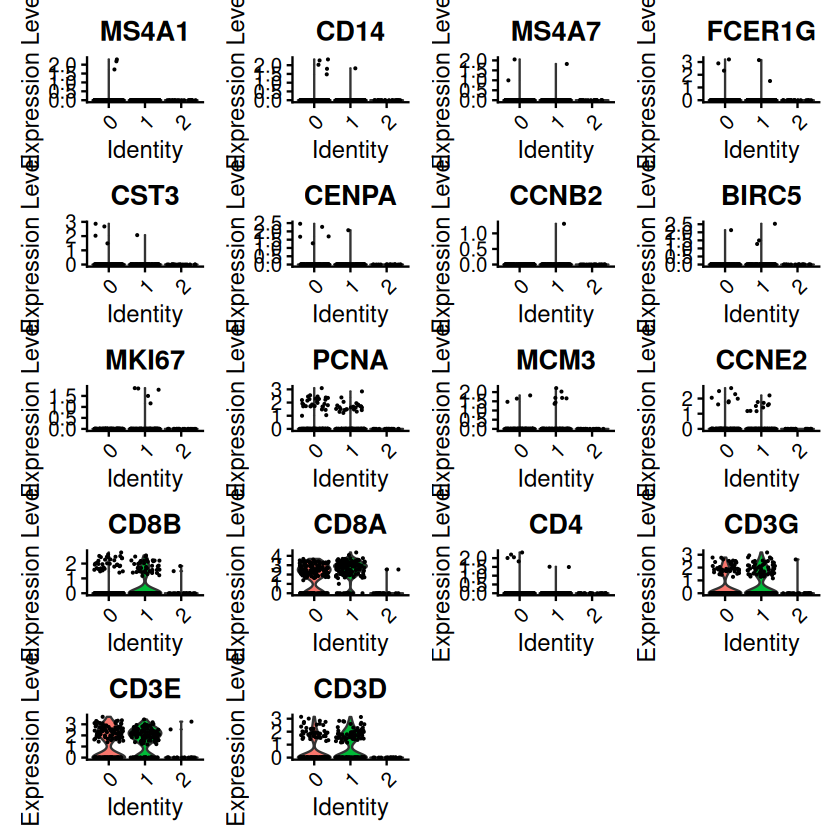

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
4.483422e-13,1.178999,0.844,0.739,7.390922e-09,0,RPS12
5.556707e-13,2.470458,0.544,0.205,9.160232e-09,0,KLF2
6.106198e-13,1.284557,0.856,0.646,1.006607e-08,0,HEXIM1
2.194644e-12,1.081544,0.881,0.776,3.617871e-08,0,RPL27A
3.474314e-12,1.030590,0.875,0.807,5.727407e-08,0,RPS6
3.077183e-11,4.064874,0.306,0.031,5.072736e-07,0,IL7R
4.825531e-11,1.027124,0.875,0.807,7.954889e-07,0,RPS20
5.591202e-11,1.060104,0.844,0.671,9.217097e-07,0,RPS3
1.416751e-10,1.229794,0.875,0.727,2.335513e-06,0,VIM


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
EEF1A1,1.590835e-21,0.9634316,0.975,0.944,2.622491e-17,0,EEF1A1
RPS29,8.862823e-15,0.8704680,0.950,0.932,1.461036e-10,0,RPS29
RPS12,4.483422e-13,1.1789995,0.844,0.739,7.390922e-09,0,RPS12
KLF2,5.556707e-13,2.4704577,0.544,0.205,9.160232e-09,0,KLF2
HEXIM1,6.106198e-13,1.2845573,0.856,0.646,1.006607e-08,0,HEXIM1
TPT1,1.950450e-12,0.8159304,0.938,0.907,3.215316e-08,0,TPT1
RPL27A,2.194644e-12,1.0815442,0.881,0.776,3.617871e-08,0,RPL27A
RPS6,3.474314e-12,1.0305905,0.875,0.807,5.727407e-08,0,RPS6
RPL34,2.399017e-11,0.8900351,0.950,0.863,3.954780e-07,0,RPL34


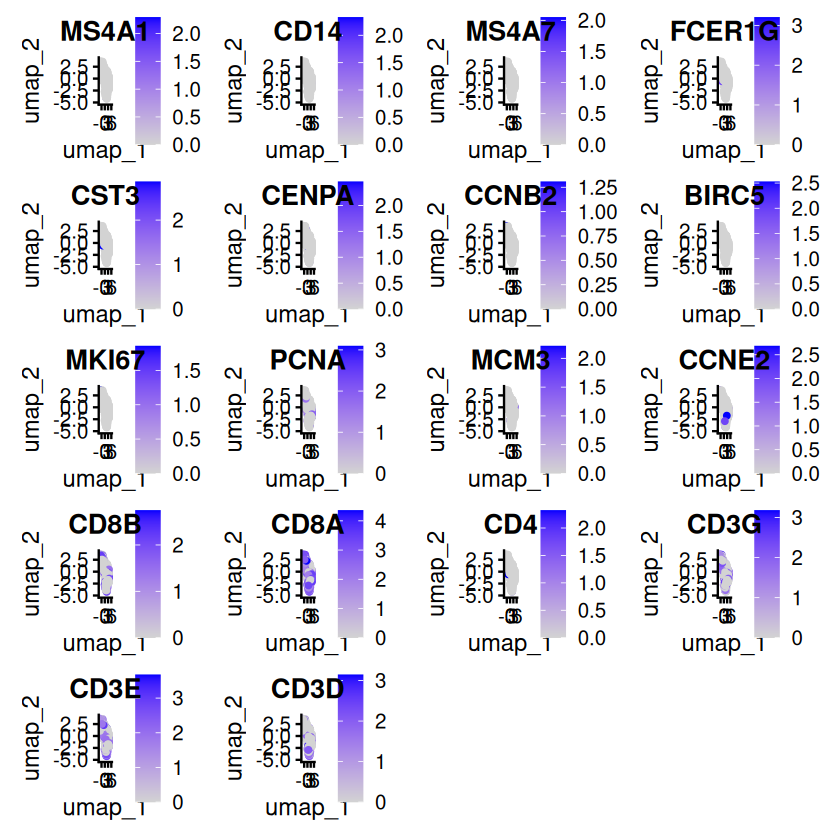

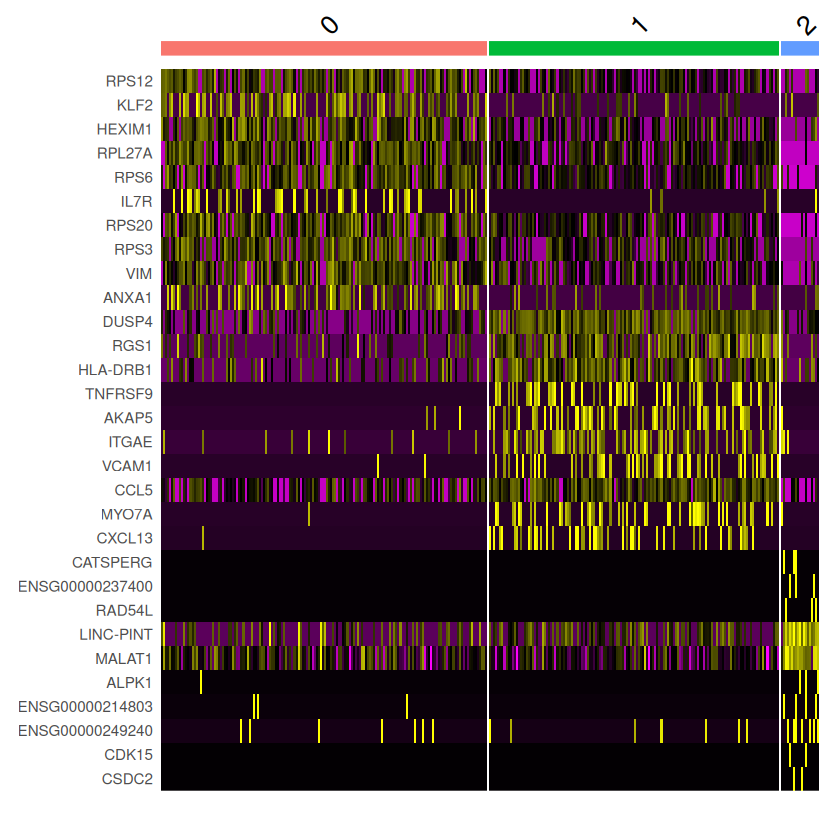

In [58]:
# Marker expression visualization
#VlnPlot(zehn_s, features = c("JADE2", "DEK", "CDK2AP2")) #Cluster 1 could represent a population of activated or metabolically active cells (since all three genes are upregulated). Cluster 3 might represent a transition or differentiation state. Clusters 0 and 2 are likely in a resting or low-activity state.
#FeaturePlot(zehn_s, features = c("JADE2", "DEK", "CDK2AP2","EFNB2", "ENSG00000267458", "FAM53C", "PMF1", "PTMS", "SERP1", "WBP11"))
VlnPlot(zehn_s, features = present_features) #Cluster 1 could represent a population of activated or metabolically active cells (since all three genes are upregulated). Cluster 3 might represent a transition or differentiation state. Clusters 0 and 2 are likely in a resting or low-activity state.
FeaturePlot(zehn_s, features = present_features)


zehn_s.markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > 1) %>%
  slice_head(n = 10) %>%
  ungroup() -> top10
top10 # What's a tibble?
zehn_s.markers
DoHeatmap(zehn_s, features = top10$gene) + NoLegend()

In [59]:
ncol(zehn_s.markers)
nrow(zehn_s.markers)
colnames(zehn_s.markers) # 2365
head(zehn_s.markers)

[1] 7

[1] 1771

[1] "p_val"      "avg_log2FC" "pct.1"      "pct.2"      "p_val_adj" 
[6] "cluster"    "gene"

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
EEF1A1,1.590835e-21,0.9634316,0.975,0.944,2.622491e-17,0,EEF1A1
RPS29,8.862823e-15,0.8704680,0.950,0.932,1.461036e-10,0,RPS29
RPS12,4.483422e-13,1.1789995,0.844,0.739,7.390922e-09,0,RPS12
KLF2,5.556707e-13,2.4704577,0.544,0.205,9.160232e-09,0,KLF2
HEXIM1,6.106198e-13,1.2845573,0.856,0.646,1.006607e-08,0,HEXIM1
TPT1,1.950450e-12,0.8159304,0.938,0.907,3.215316e-08,0,TPT1


In [60]:
# Assigning cell type identity to clusters ## How to?

#library(SingleR)
#BiocManager::install("SingleR")
#BiocManager::install("celldex")
#library(celldex)

In [61]:
#ref <- celldex::HumanPrimaryCellAtlasData()

#pred <- SingleR(test = GetAssayData(zehn_s, slot = "data"), ref = ref, labels = ref$label.main)
#colnames(zehn_s)
#colnames(zehn_s@meta.data) # The correct way
#zehn_s$SingleR.labels <- pred$labels
#zehn_s$SingleR.labels

In [62]:
#zehn_s$SingleR.labels <- pred$labels
#new.cluster.ids <- pred$labels
#names(new.cluster.ids) <- levels(zehn_s)
#zehn_s <- RenameIdents(zehn_s, new.cluster.ids)
#DimPlot(zehn_s, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [63]:
#table(is.na(pred$labels))

In [64]:
# Visualization vignette

library(SeuratData)

ERROR: Error in library(SeuratData): there is no package called ‘SeuratData’


✅ Present genes:
       B       MM       MM       MM   Mphase   Mphase   Mphase   Sphase 
 "MS4A1"   "CD14" "FCER1G"   "CST3"  "CENPA"  "BIRC5"  "MKI67"   "PCNA" 
  Sphase   Sphase        T        T        T        T        T        T 
  "MCM3"  "CCNE2"   "CD8B"   "CD8A"    "CD4"   "CD3G"   "CD3E"   "CD3D" 

❌ Missing genes:
         B         MM         MM         MM         MM         MM       rRNA 
    "CD19"     "LYZ2"    "FCGR3"    "MS4A7"    "H2-AA"     "LY6D" "AY036118" 
      rRNA     Mphase 
 "GM42418"    "CCNB2" 


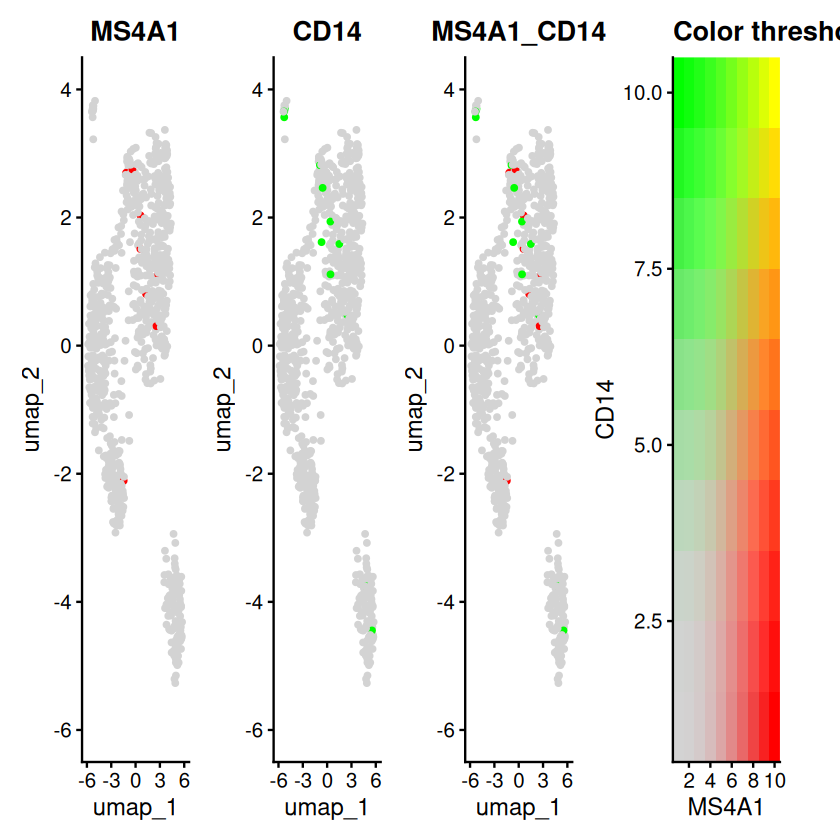

In [78]:
library(ggplot2)
library(patchwork)

features = c(B='Ms4a1',B='Cd19',MM='Cd14',MM='Lyz2',MM='Fcgr3',MM='Ms4a7',MM='Fcer1g',MM='Cst3',MM='H2-Aa',MM='Ly6d',
  rRNA='AY036118',rRNA='Gm42418',Mphase='Cenpa',Mphase='Ccnb2',Mphase='Birc5',Mphase='Mki67',Sphase='Pcna',
  Sphase='Mcm3',Sphase='Ccne2','T'='Cd8b','T'='Cd8a','T'='Cd4','T'='Cd3g','T'='Cd3e','T'='Cd3d')

# Convert all gene symbols to uppercase
features_upper <- toupper(features)

# Now check against the Seurat object
present_features <- features_upper[features_upper %in% rownames(zehn_s)]
missing_features <- features_upper[!features_upper %in% rownames(zehn_s)]

cat("✅ Present genes:\n")
print(present_features)

cat("\n❌ Missing genes:\n")
print(missing_features)

# Visualize #co-expression# of two features simultaneously # Yellow = red+green?
FeaturePlot(zehn_s, features = present_features[1:2], blend = TRUE)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<fct>
111840,zehn_dataset,3231,1490,14.020427,2133,1386,3,3
146164,zehn_dataset,2897,1317,11.287539,2022,1261,0,0
166368,zehn_dataset,2204,1003,13.793103,1927,977,4,4
205244,zehn_dataset,815,564,9.693252,1454,563,1,1
289640,zehn_dataset,1258,906,4.848967,1379,873,0,0
393118,zehn_dataset,705,472,21.843972,1313,479,2,2


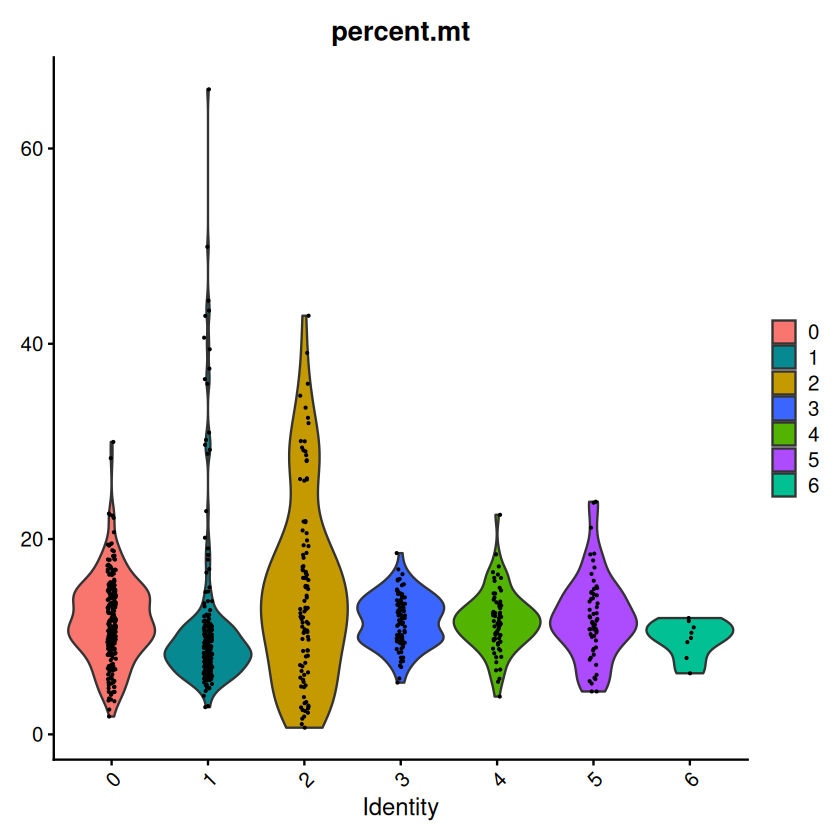

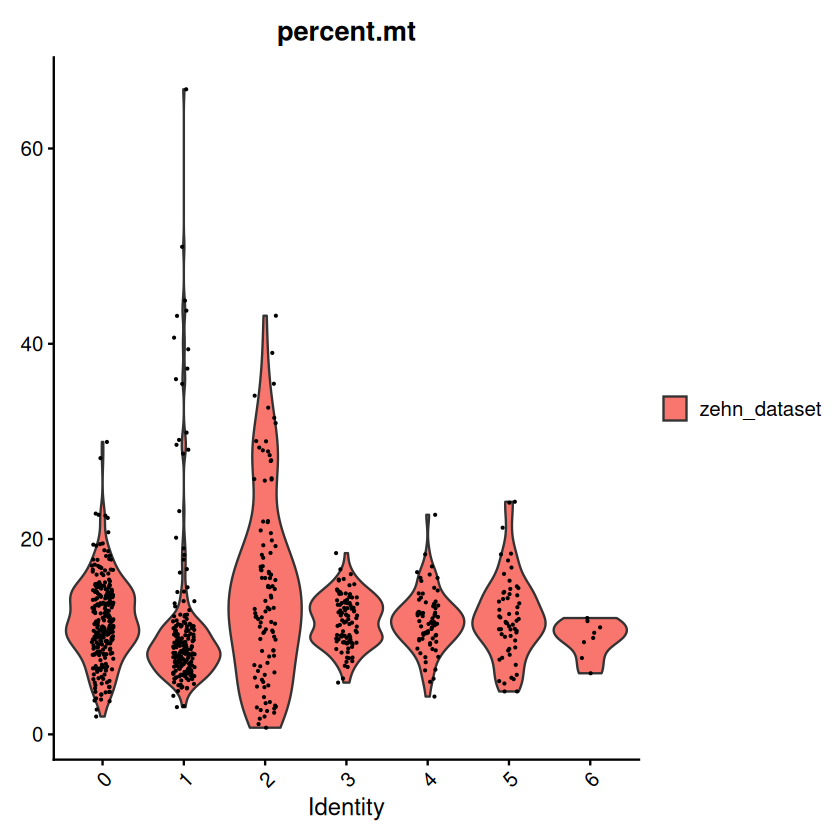

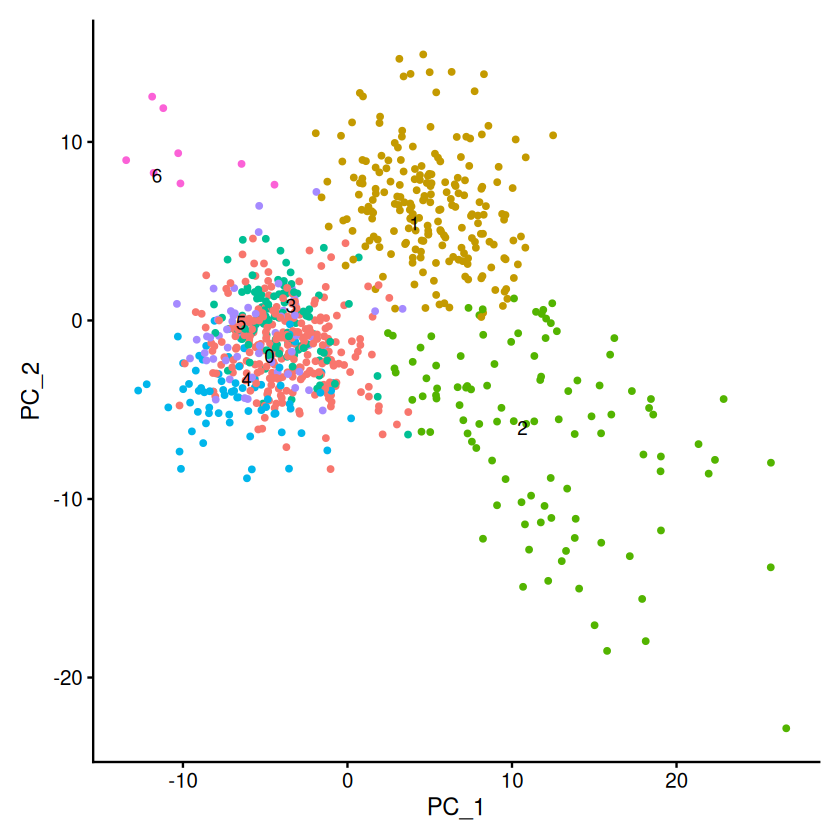

In [76]:
head(zehn_s@meta.data)
VlnPlot(zehn_s, features = "percent.mt", split.by = "seurat_clusters")
#VlnPlot(zehn_s, features = "percent.mt", split.by = "SingleR.labels")
VlnPlot(zehn_s, features = "percent.mt", split.by = "orig.ident")

#DotPlot(zehn_s, features = present_features, split.by = "SingleR.labels", 
#        cols = c("blue", "red", "green")) + RotatedAxis() ## Combined labels for meaningful grouping

#DoHeatmap(zehn_s, features = VariableFeatures(zehn_s)[1:20], cells = 1:42, size = 4,
#          angle = 90) + NoLegend()

plot <- DimPlot(zehn_s, reduction = "pca") + NoLegend()
LabelClusters(plot = plot, id = "ident")

Picking joint bandwidth of 3.54e-06

Picking joint bandwidth of 3.61e-06

Picking joint bandwidth of 3.58e-06

Picking joint bandwidth of 3.6e-06

Picking joint bandwidth of 3.6e-06

Picking joint bandwidth of 3.6e-06

Picking joint bandwidth of 3.52e-06

Picking joint bandwidth of 3.6e-06

Picking joint bandwidth of 3.54e-06

Picking joint bandwidth of 4.43e-06

Picking joint bandwidth of 3.61e-06

Picking joint bandwidth of 3.65e-06

Picking joint bandwidth of 0.0953

Picking joint bandwidth of 0.212

Picking joint bandwidth of 3.62e-06

Picking joint bandwidth of 0.212

Picking joint bandwidth of 0.254

Picking joint bandwidth of 0.21



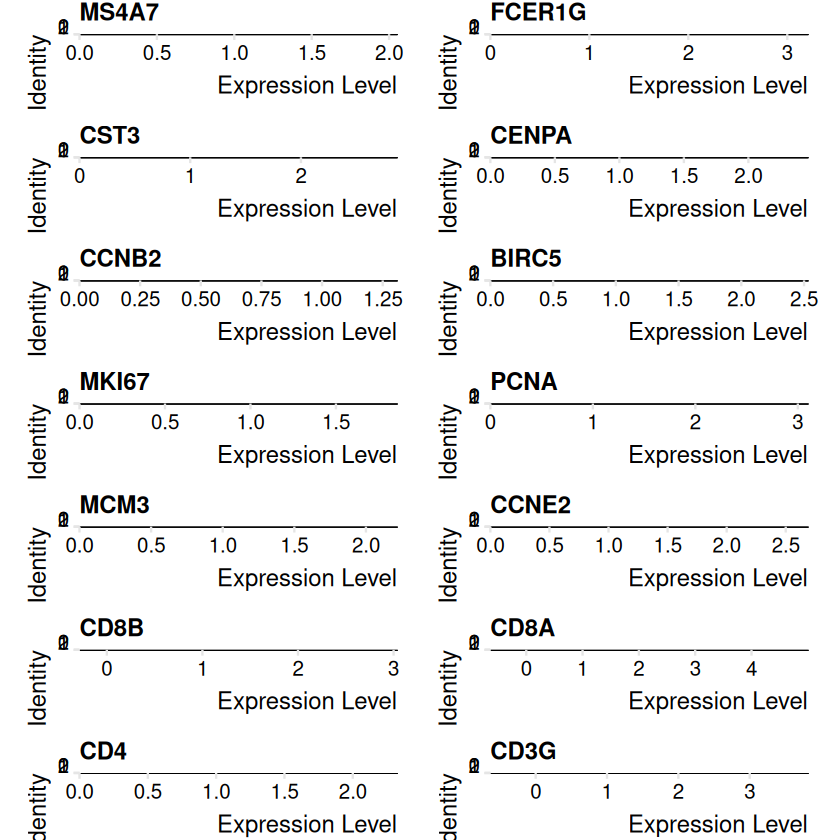

In [67]:
#----------------Ridge plots
RidgePlot(zehn_s, features = present_features, ncol = 2) # Visualize single cell expression distributions in each cluster

#Idents(zehn_s)
#table(zehn_s$SingleR.labels)

#markers <- FindAllMarkers(zehn_s, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
#head(markers)

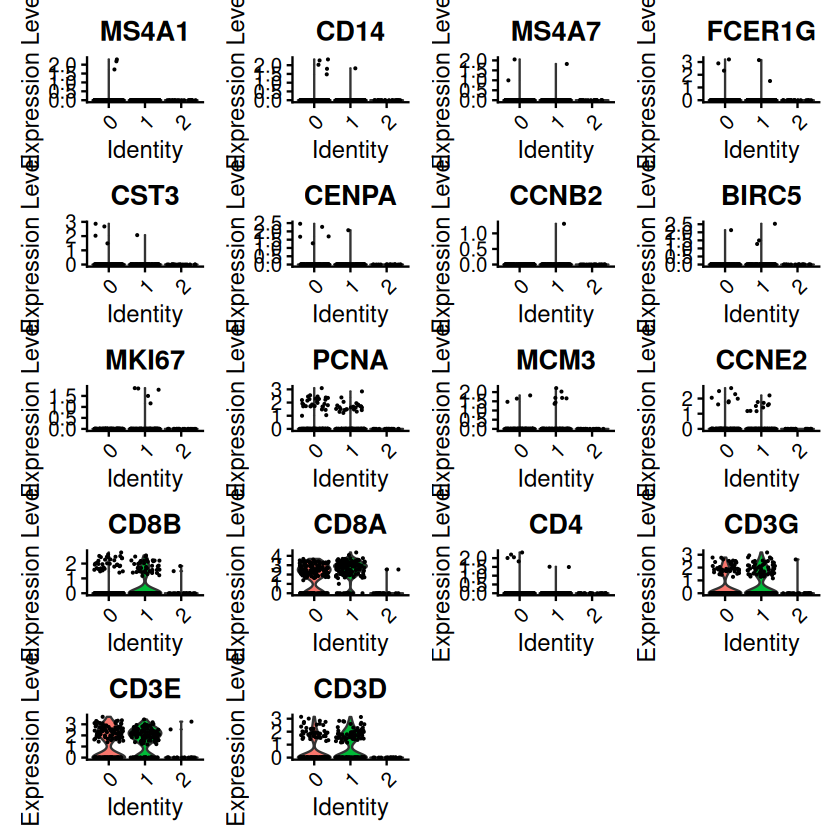

In [68]:
#----------------Vioin plots
VlnPlot(zehn_s, features = present_features)

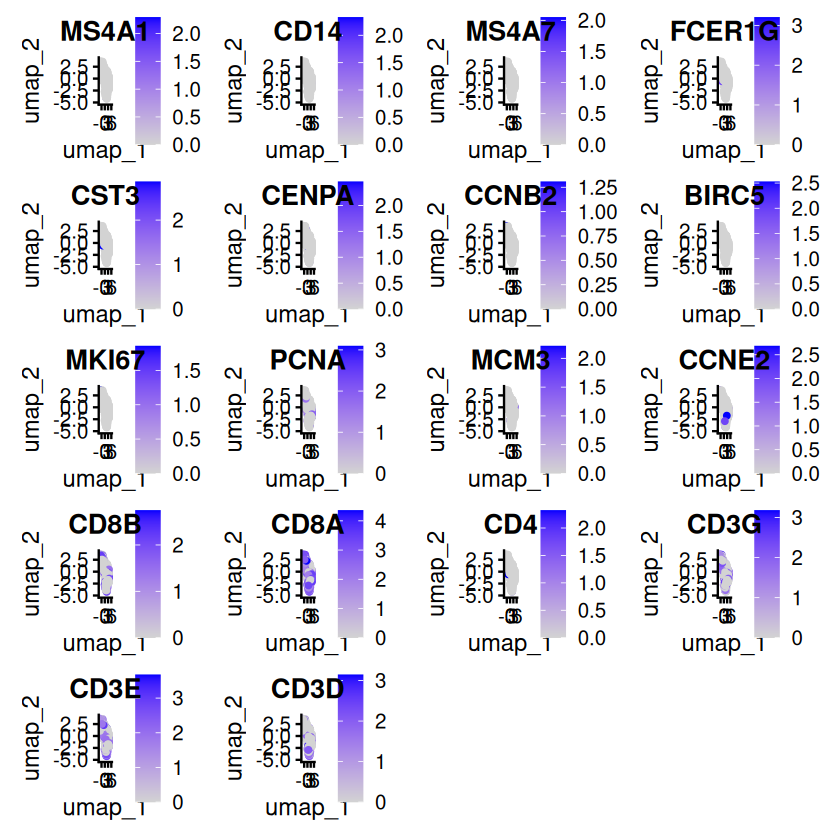

In [69]:
#----------------Feauture plots
FeaturePlot(zehn_s, features = present_features)

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


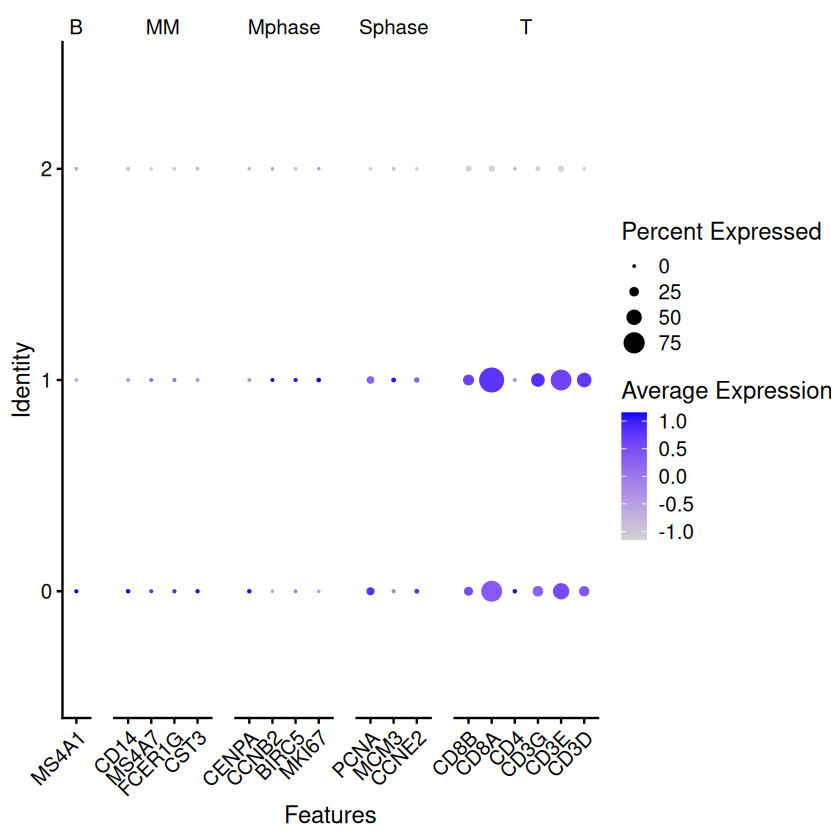

In [70]:
# DotPlots
DotPlot(zehn_s, features = present_features) + RotatedAxis() #per gene

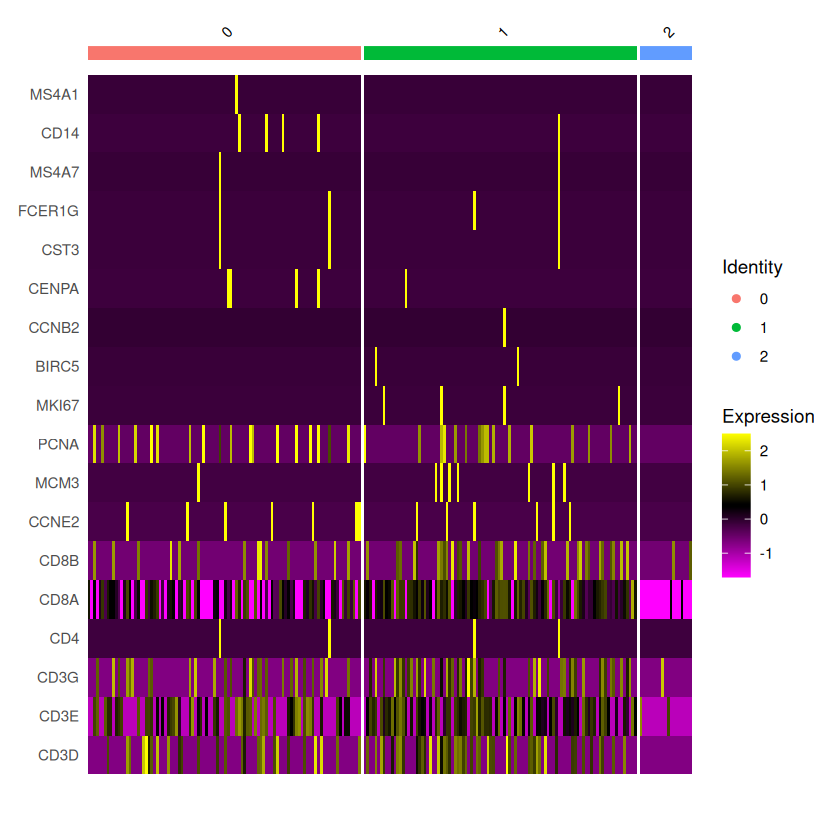

In [71]:
DoHeatmap(subset(zehn_s, downsample = 100), features = present_features, size = 3) # NK cells inflated due to hierarchical clustering??

In [72]:
head(rownames(zehn_s), 20)

[1] "A1BG-AS1"  "A2M"       "A2M-AS1"   "A2ML1"     "A2ML1-AS1" "A3GALT2"  
 [7] "AAAS"      "AACS"      "AACSP1"    "AAGAB"     "AAK1"      "AAMDC"    
[13] "AAMP"      "AAR2"      "AARS1"     "AARS2"     "AARSD1"    "AASDH"    
[19] "AASDHPPT"  "AASS"

`vst.flavor` is set to 'v2' but could not find glmGamPoi installed.
Please install the glmGamPoi package for much faster estimation.
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('glmGamPoi')
--------------------------------------------
Falling back to native (slower) implementation.


Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = co

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
“iteration limit reached”
Warning message in theta.ml(Y, m

[1] 802

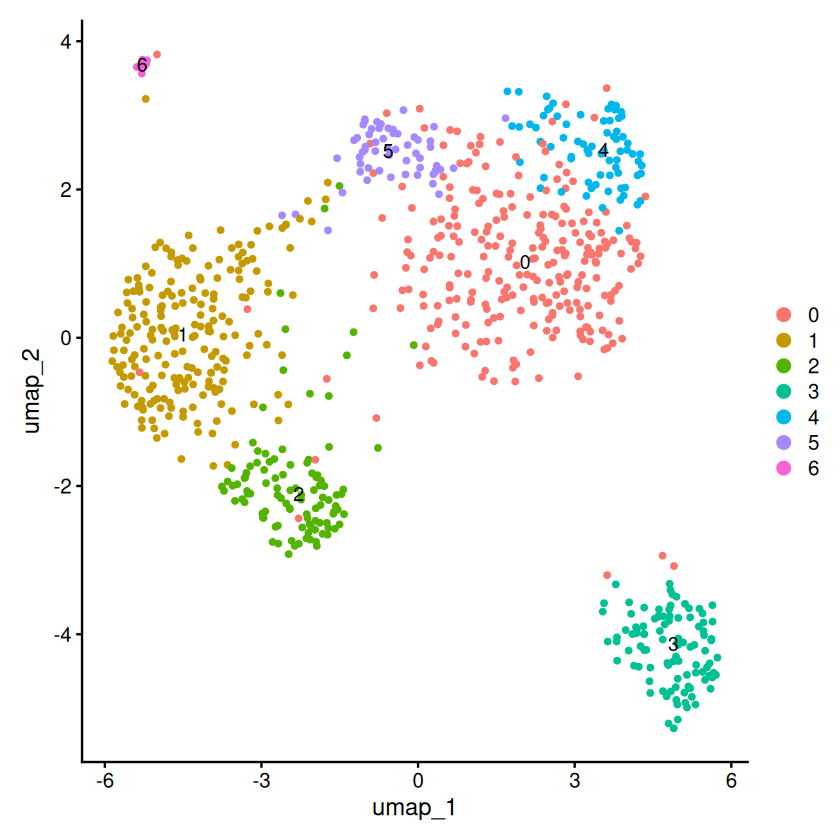

In [73]:
# SCTransform

library(Seurat)
library(ggplot2)
library(sctransform)

#install.packages('BiocManager')
#BiocManager::install('glmGamPoi')

# run sctransform
# this single command replaces NormalizeData(), ScaleData(), and FindVariableFeatures() #install glmGamPoi
zehn_s <- SCTransform(zehn, vars.to.regress = "percent.mt", verbose = FALSE) #No filtering based on mito. contamination

# Standard steps in the Seurat workflow for visualization and clustering
#PCA and UMAP embedding
zehn_s <- RunPCA(zehn_s, verbose = FALSE)
zehn_s <- RunUMAP(zehn_s, dims = 1:20, verbose = FALSE)

zehn_s <- FindNeighbors(zehn_s, dims = 1:20, verbose = FALSE)
zehn_s <- FindClusters(zehn_s, verbose = FALSE)
DimPlot(zehn_s, label = TRUE)

ncol(zehn_s)

# Visualize canonical marker genes on the sctransform embedding.